[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ruifcruz/WCARS_2025/blob/main/3.Chat_with_an_Excel_file/3_Chat_with_an_Excel_file.ipynb)


# Generative AI applications with python
@Francisco Cruz - francisco.cruz@iscte-iul.pt

# App 3 - Chat with an Excel file

The objective of the code in this notebook is to communicate with the data of an Excel file. This is achieved by converting the data into a SQL table and then having an LLM building a query to gathre information from that table.

**Note**: There are several alternatives to OpenAI which provide LLM models with similar quality (Claude, Mistral, Gemini, Deepseek, HuggingFace, etc)

# 0. Preparation steps

In [1]:
# Download and install openai package on the computer
%%capture
!pip install langgraph==0.4.1 langchain-community==0.3.23 langchain-openai==0.3.16

In [2]:
# We need to instruct the computer to access the packages that will be needed along the notebook
# pandas package is needed to store data on a table
import pandas as pd
import os
# google.colab package is needed to access client secrets (explained on the next cells) and download output files
from google.colab import userdata, files
# IPython and json packages are needed to print easier to read outputs
from IPython.display import Image, display, Markdown
# sqlite3 is needed to create a SQL database
import sqlite3
# langchain and langgraph packages are needed to build the agent
from langchain.utilities import SQLDatabase
from langchain.chat_models import init_chat_model
from langchain_community.agent_toolkits import SQLDatabaseToolkit
from langgraph.prebuilt import create_react_agent

In [3]:
# Creating a function that will be useful ahead
def print_text(text):
  display(Markdown(text))

To access OpenAI's services, you need to have a password (api key).

To obtain one, you must create an account at https://platform.openai.com/, go to 'API keys' and create a key. You will need to have a payment method associated with your account.

The key can be placed directly in the code, but that is not considered secure. Therefore, in Colab you can use the 'Secrets' tab (on the left), where you can add a line with:
- 'Name' equal to OPENAI_API_KEY
- 'Value' equal to the key"

In [4]:
# The computer will read and store the key that was pasted on the tab "Secrets"
os.environ["OPENAI_API_KEY"] = userdata.get('OPENAI_API_KEY')

# 1. Read the excel file and convert it to a SQL table

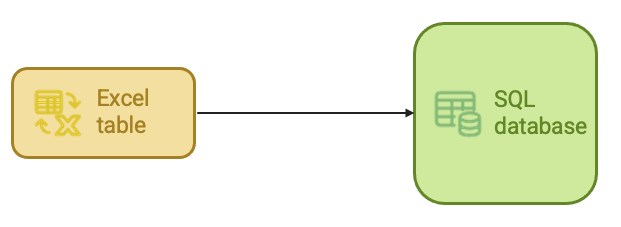

In [6]:
# Read a balance sheet which is stored online
df = pd.read_excel("https://raw.githubusercontent.com/ruifcruz/WCARS_2025/main/3.Chat_with_an_Excel_file/source_data/balance_sheet.xlsx", header=0)
df

,Account,Description,Month_Debit,Month_Credit,Debit,Credit,Debtor,Creditor,Net
0,111,Bank 222,0.000000,0.0,6.367454e+04,5.985724e+04,3817.302609,0.000000,3817.302609
1,1201,Bank 402,0.000000,0.0,9.769665e+06,9.756055e+06,13610.112828,0.000000,13610.112828
2,1202,Bank 404,0.000000,0.0,5.362396e+05,5.277678e+05,8471.816683,0.000000,8471.816683
3,1204,Bank 408,0.000000,0.0,3.110519e+06,3.086866e+06,23653.023038,0.000000,23653.023038
4,1205,Bank 410,0.000000,0.0,2.604813e+06,2.597723e+06,7090.250235,0.000000,7090.250235
...,...,...,...,...,...,...,...,...,...
698,7886,Internal Expense 2658,0.000000,0.0,0.000000e+00,4.384908e+03,0.000000,4384.907800,-4384.907800
699,788899,Internal Expense 2697,0.000000,0.0,0.000000e+00,7.638174e+03,0.000000,7638.174328,-7638.174328
700,8121,Internal Expense 363,11210.970982,0.0,1.121097e+04,0.000000e+00,11210.970982,0.000000,11210.970982
701,8122,Internal Expense 366,45876.085395,0.0,4.587609e+04,0.000000e+00,45876.085395,0.000000,45876.085395


In [7]:
# Create a SQLite database and connect to it
conn = sqlite3.connect('imported_data.db')

# Write the DataFrame to a SQLite table
df.to_sql('balance_sheet', conn, if_exists='replace', index=False)

# Close the connection
conn.close()

In [8]:
# Create a variable db which stores the database in memory
db = SQLDatabase.from_uri("sqlite:///imported_data.db")

In [9]:
# Check that the table was created correctly
db.get_usable_table_names()

['balance_sheet']

In [10]:
print_text(db.get_table_info(["balance_sheet"]))


CREATE TABLE balance_sheet (
	"Account" INTEGER, 
	"Description" TEXT, 
	"Month_Debit" REAL, 
	"Month_Credit" REAL, 
	"Debit" REAL, 
	"Credit" REAL, 
	"Debtor" REAL, 
	"Creditor" REAL, 
	"Net" REAL
)

/*
3 rows from balance_sheet table:
Account	Description	Month_Debit	Month_Credit	Debit	Credit	Debtor	Creditor	Net
111	Bank 222	0.0	0.0	63674.542698	59857.2400894	3817.3026085999954	0.0	3817.3026085999954
1201	Bank 402	0.0	0.0	9769665.0590058	9756054.9461778	13610.11282800138	0.0	13610.11282800138
1202	Bank 404	0.0	0.0	536239.6399828	527767.8232996	8471.816683199955	0.0	8471.816683199955
*/

In [11]:
# Let's create a function to test some SQL queries to the database
def run_query(query):
  conn = sqlite3.connect('imported_data.db')
  cursor = conn.cursor()

  # Execute the query
  cursor.execute(query)

  # Fetch all results
  results = cursor.fetchall()

  # Print the results
  for row in results:
      print(row)

  # Close the connection
  conn.close()


In [12]:
# Run some test query
run_query("SELECT * FROM balance_sheet WHERE Account LIKE '21%' LIMIT 10")

(2111110013, 'Client 39', 0.0, 0.0, 354335.3964176, 302232.3631834, 52103.033234199975, 0.0, 52103.033234199975)
(2111110181, 'Client 543', 0.0, 0.0, 2952.9076278, 2952.9076278, 0.0, 0.0, 0.0)
(2111110183, 'Client 549', 0.0, 0.0, 27131.2601014, 0.0, 27131.2601014, 0.0, 27131.2601014)
(2111110190, 'Client 570', 0.0, 0.0, 11512.058272, 11356.1682442, 155.8900278000001, 0.0, 155.8900278000001)
(2111110197, 'Client 591', 0.0, 0.0, 145.0661524, 0.0, 145.0661524, 0.0, 145.0661524)
(2111110205, 'Client 615', 0.0, 0.0, 23915.95726, 22859.7334888, 1056.2237711999987, 0.0, 1056.2237711999987)
(2111110212, 'Client 636', 0.0, 0.0, 12633.3272702, 12633.3272702, 0.0, 0.0, 0.0)
(2111110219, 'Client 657', 0.0, 0.0, 1516.4497088, 1516.4497088, 0.0, 0.0, 0.0)
(2111110222, 'Client 666', 0.0, 0.0, 1040.6653608, 1034.605156, 6.060204799999838, 0.0, 6.060204799999838)
(2111110225, 'Client 675', 0.0, 0.0, 4370.34, 4370.34, 0.0, 0.0, 0.0)


# 2. Use a SQL agent to analize the table

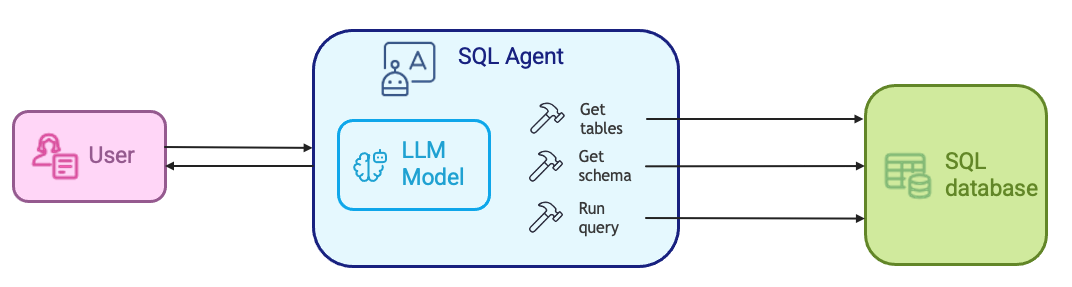

In [13]:
# Setuo the LLM that will be the "brain" of the agent
llm = init_chat_model("openai:gpt-4.1")

In [14]:
# Create a toolkit, which includes all that tools that can be used on a SQLite database
toolkit = SQLDatabaseToolkit(db=db, llm=llm)
tools = toolkit.get_tools()

 # Print the names and descriptions of the tools
for tool in tools:
    print(f"{tool.name}: {tool.description}\n")

sql_db_query: Input to this tool is a detailed and correct SQL query, output is a result from the database. If the query is not correct, an error message will be returned. If an error is returned, rewrite the query, check the query, and try again. If you encounter an issue with Unknown column 'xxxx' in 'field list', use sql_db_schema to query the correct table fields.

sql_db_schema: Input to this tool is a comma-separated list of tables, output is the schema and sample rows for those tables. Be sure that the tables actually exist by calling sql_db_list_tables first! Example Input: table1, table2, table3

sql_db_list_tables: Input is an empty string, output is a comma-separated list of tables in the database.

sql_db_query_checker: Use this tool to double check if your query is correct before executing it. Always use this tool before executing a query with sql_db_query!



In [15]:
# Create a system prompt. This is the instruction given to the LLM
system_prompt = """
You are an agent designed to interact with a SQL database.
Given an input question, create a syntactically correct sqlite query to run,
then look at the results of the query and return the answer. Unless the user
specifies a specific number of examples they wish to obtain, always limit your
query to at most 5 results.

You can order the results by a relevant column to return the most interesting
examples in the database. Never query for all the columns from a specific table,
only ask for the relevant columns given the question.

You MUST double check your query before executing it. If you get an error while
executing a query, rewrite the query and try again.

DO NOT make any DML statements (INSERT, UPDATE, DELETE, DROP etc.) to the
database.

To start you should ALWAYS look at the tables in the database to see what you
can query. Do NOT skip this step.

Then you should query the schema of the most relevant tables.
"""

In [16]:
# Create an agent that is a composition of an LLM, a set of tools and a system prompt
agent = create_react_agent(
    llm,
    tools,
    prompt=system_prompt,
)

In [17]:
# Create a function that prints all the steps taken by the agent to get a response
def ask_agent(question):
  for step in agent.stream(
      {"messages": [{"role": "user", "content": question}]},
      stream_mode="values",
  ):
      step["messages"][-1].pretty_print()

In [18]:
ask_agent("How many rows are there on the balance sheet?")

================================ Human Message =================================

How many rows are there on the balance sheet?
================================== Ai Message ==================================
Tool Calls:
  sql_db_list_tables (call_XAr1dcprJ1D21nDJ1EpuP2Gk)
 Call ID: call_XAr1dcprJ1D21nDJ1EpuP2Gk
  Args:
================================= Tool Message =================================
Name: sql_db_list_tables

balance_sheet
================================== Ai Message ==================================
Tool Calls:
  sql_db_schema (call_ipYTDoR9z7bQkHy4XptG0y30)
 Call ID: call_ipYTDoR9z7bQkHy4XptG0y30
  Args:
    table_names: balance_sheet
================================= Tool Message =================================
Name: sql_db_schema


CREATE TABLE balance_sheet (
	"Account" INTEGER, 
	"Description" TEXT, 
	"Month_Debit" REAL, 
	"Month_Credit" REAL, 
	"Debit" REAL, 
	"Credit" REAL, 
	"Debtor" REAL, 
	"Creditor" REAL, 
	"Net" REAL
)

/*
3 rows from balance_sheet tabl

In [19]:
ask_agent("what is the maximum debit amount for account numbers that start with 21? What is the name of the Client?")

================================ Human Message =================================

what is the maximum debit amount for account numbers that start with 21? What is the name of the Client?
================================== Ai Message ==================================
Tool Calls:
  sql_db_list_tables (call_7X6tiFnpXhQ1OQDshJQtXbZs)
 Call ID: call_7X6tiFnpXhQ1OQDshJQtXbZs
  Args:
    tool_input:
================================= Tool Message =================================
Name: sql_db_list_tables

balance_sheet
================================== Ai Message ==================================
Tool Calls:
  sql_db_schema (call_JDjeuJ0d3sW7gLYmGOb8CYZf)
 Call ID: call_JDjeuJ0d3sW7gLYmGOb8CYZf
  Args:
    table_names: balance_sheet
================================= Tool Message =================================
Name: sql_db_schema


CREATE TABLE balance_sheet (
	"Account" INTEGER, 
	"Description" TEXT, 
	"Month_Debit" REAL, 
	"Month_Credit" REAL, 
	"Debit" REAL, 
	"Credit" REAL, 
	"Debtor"

In [20]:
ask_agent("Are there any positive creditor amounts for account numbers that start with 21?")

================================ Human Message =================================

Are there any positive creditor amounts for account numbers that start with 21?
================================== Ai Message ==================================
Tool Calls:
  sql_db_list_tables (call_oMW7D1PiJFMQqENiR0lk6SNQ)
 Call ID: call_oMW7D1PiJFMQqENiR0lk6SNQ
  Args:
================================= Tool Message =================================
Name: sql_db_list_tables

balance_sheet
================================== Ai Message ==================================
Tool Calls:
  sql_db_schema (call_i2rhpWJXw0dLZVqIFTbUNnJo)
 Call ID: call_i2rhpWJXw0dLZVqIFTbUNnJo
  Args:
    table_names: balance_sheet
================================= Tool Message =================================
Name: sql_db_schema


CREATE TABLE balance_sheet (
	"Account" INTEGER, 
	"Description" TEXT, 
	"Month_Debit" REAL, 
	"Month_Credit" REAL, 
	"Debit" REAL, 
	"Credit" REAL, 
	"Debtor" REAL, 
	"Creditor" REAL, 
	"Net" REAL
)


In [21]:
ask_agent("Are there any non-zero debtor amounts for account numbers that start with 22?")

================================ Human Message =================================

Are there any non-zero debtor amounts for account numbers that start with 22?
================================== Ai Message ==================================
Tool Calls:
  sql_db_list_tables (call_Bcp3RdRWgzRE3ThaLq3v9Pv9)
 Call ID: call_Bcp3RdRWgzRE3ThaLq3v9Pv9
  Args:
================================= Tool Message =================================
Name: sql_db_list_tables

balance_sheet
================================== Ai Message ==================================
Tool Calls:
  sql_db_schema (call_orqU8dDxAsb66NYep2S3gjYh)
 Call ID: call_orqU8dDxAsb66NYep2S3gjYh
  Args:
    table_names: balance_sheet
================================= Tool Message =================================
Name: sql_db_schema


CREATE TABLE balance_sheet (
	"Account" INTEGER, 
	"Description" TEXT, 
	"Month_Debit" REAL, 
	"Month_Credit" REAL, 
	"Debit" REAL, 
	"Credit" REAL, 
	"Debtor" REAL, 
	"Creditor" REAL, 
	"Net" REAL
)

/

In [23]:
ask_agent("What is the highest debit amount for an internal expense?")

================================ Human Message =================================

What is the highest debit amount for an internal expense?
================================== Ai Message ==================================
Tool Calls:
  sql_db_list_tables (call_kPfh7WkJ8t5Ya10tB4K0t6f5)
 Call ID: call_kPfh7WkJ8t5Ya10tB4K0t6f5
  Args:
    tool_input:
================================= Tool Message =================================
Name: sql_db_list_tables

balance_sheet
================================== Ai Message ==================================
Tool Calls:
  sql_db_schema (call_irVDGq7kZcmLCZFxtC3AQzuA)
 Call ID: call_irVDGq7kZcmLCZFxtC3AQzuA
  Args:
    table_names: balance_sheet
================================= Tool Message =================================
Name: sql_db_schema


CREATE TABLE balance_sheet (
	"Account" INTEGER, 
	"Description" TEXT, 
	"Month_Debit" REAL, 
	"Month_Credit" REAL, 
	"Debit" REAL, 
	"Credit" REAL, 
	"Debtor" REAL, 
	"Creditor" REAL, 
	"Net" REAL
)

/*
3 